# AIRDOS G data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob

In [3]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [3]:
#fto = './data/malaga/16/DATALOG.TXT' #  File to Open
#fto = './data/malaga/21/DATALOG.TXT' #  File to Open
fto = './data/malaga/98/DATALOG.TXT' #  File to Open
#fto = './data/malaga/F0/DATALOG.TXT' #  File to Open

print (fto)

l=[]
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS'][3]
print (sn[0])

./data/malaga/98/DATALOG.TXT
1290c00806a200912821a000a0000098


## Derive measurement runs in to separate files

In [12]:
run = 0

runs = []
LatDD = np.nan
LatD = np.nan
LatM = np.nan
LonDD = np.nan
LonD = np.nan
LonM = np.nan
LatHem = ''
LonHem = ''

for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        flag = 0
        flagrun = 0
        print (run, end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        LatHem = r.astype(str)[4]
        LonHem = r.astype(str)[6]
        if (LatHem=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (LonHem=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatD = np.trunc(Lat/100)
        LatM = ((Lat/100) - LatD) * 100
        LatDD = LatD + LatM/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonD = np.trunc(Lon/100)
        LonM = ((Lon/100) - LonD) * 100
        LonDD = LonD + LonM/60.0
        LonDD = LonDD * LonS         
        flag = 1
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'latD'] = LatD
        df.at[i,'lonD'] = LonD
        df.at[i,'latM'] = LatM
        df.at[i,'lonM'] = LonM
        df.at[i,'latHem'] = LatHem
        df.at[i,'lonHem'] = LonHem
        
  
FROM = pd.to_datetime('2019-11-26 00:00:00')
TO = pd.to_datetime('2019-11-29 01:10:00')
#FROM = pd.to_datetime('2019-11-26 00:00:00')
#TO = pd.to_datetime('2019-11-30 01:10:00')
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-29 01:00:00')
#PRG-AGP
#FROM = pd.to_datetime('2019-11-28 18:55:00')
#TO = pd.to_datetime('2019-11-28 20:55:00')
#AGP-PRG
#FROM = pd.to_datetime('2019-11-28 23:00:00')
#TO = pd.to_datetime('2019-11-29 00:30:00')


dfo = df.copy()
dfo = dfo.loc[(dfo['date']>FROM)&(dfo['date']<TO)]

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)
dfdeg = df[['latD','latM','latHem','lonD','lonM','lonHem','altitude','run','date']].copy()
dfdeg['altitude'] *= 3.28084
dfdeg['minute'] = 0
dfo['minute'] = 0
dfdeg = dfdeg.loc[(dfdeg['date']>FROM)&(dfdeg['date']<TO)]
#dfdeg.reset_index(inplace=True)

dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)

print ()

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print ('Deleting', f)
    os.remove(f)


dfo.set_index('date', inplace = True)

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)

for x in runs: 
    filename = './output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0])
    # Disimetric values
    dfo.loc[dfo['run'] == x[0],'minute'] = (pd.to_timedelta(dfo.loc[dfo['run'] == x[0]].index-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
    dfo.loc[dfo['run'] == x[0]].to_csv(filename + '.csv')

    # zeroing minutes for CARI
    zerominutes = np.round((pd.to_timedelta(dfdeg.iloc[0,8]-(x[1] + pd.to_timedelta(-x[2], unit='s')))).total_seconds()/60,0)

    # Telemetry for CARI 7
    with open(filename + '.DEG', 'w') as f:
        f.write('01/2002, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    with open('ble.DEG', 'w') as f:
        f.write('11/2019, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(-dfdeg.iloc[0,8]+dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-119    
    #dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)-zerominutes
    dfdeg.loc[dfdeg['run'] == x[0],['latD','latM', 'latHem', 'lonD', 'lonM', 'lonHem', 'altitude', 'minute']].dropna().drop_duplicates(subset='minute', keep='first').to_csv('ble.DEG', mode='a', index=False, header=False, line_terminator='\r\n')

print('End')

1
Deleting ./output/2019-11-28 16:55:13_1290c00806a200912821a000a0000098.csv
End


98.csv
2019-11-28 16:55:13_1290c00806a200912821a000a0000098.csv
        4     5  6
10  18825  3091  5
11  18975  2982  4
f0.csv
2019-11-28 16:55:18_1290c00806a20090f457a000a00000f0.csv
        4     5   6
10  17297  4189  12
11  17266  4234  18
16.csv
2019-11-28 16:55:11_1290c00806a20091702fa000a0000016.csv
        4     5   6
10  16408  5198  16
11  16607  5064  15
21.csv
2019-11-28 16:55:09_1290c00806a200912457a000a0000021.csv
        4    5  6
10  16089  252  2
11  16155  226  5


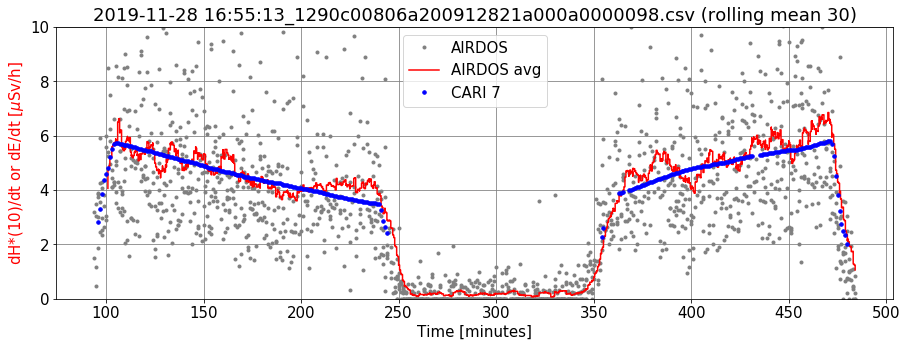

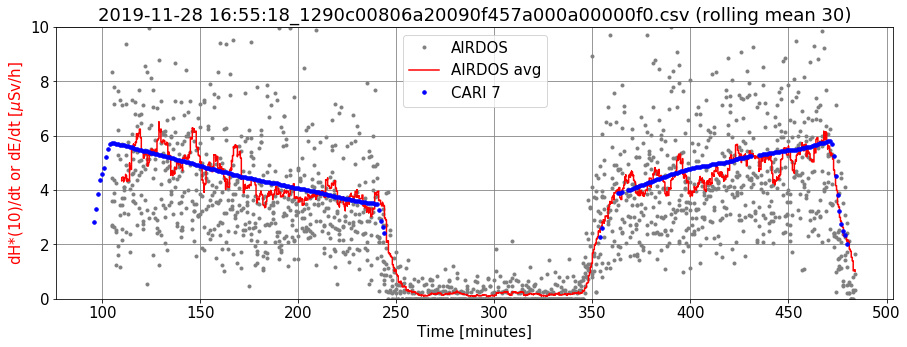

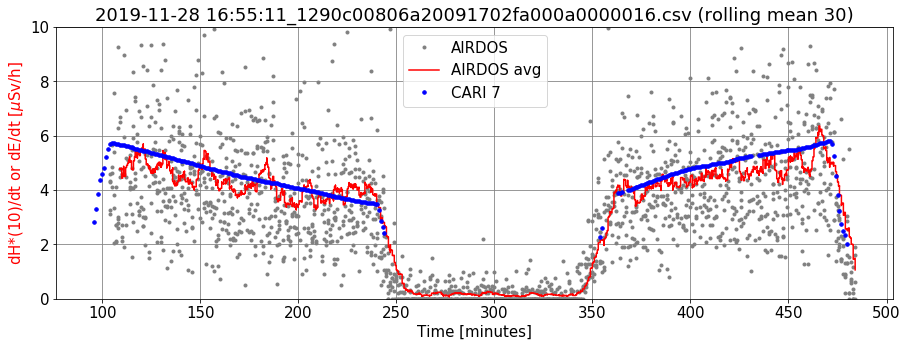

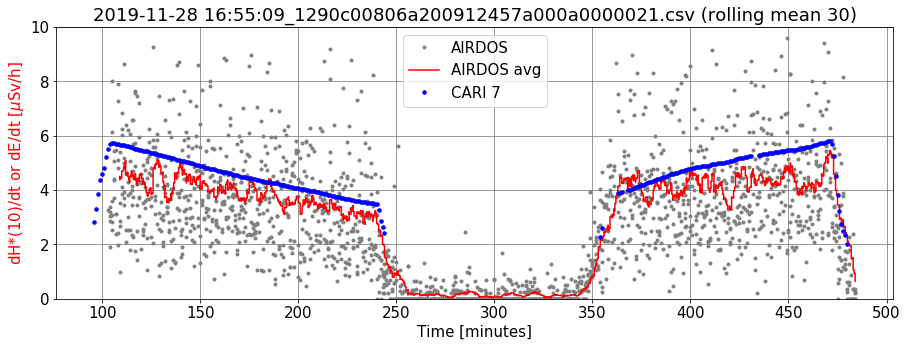

In [49]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
BASE_ENERGY = 3
LAST_CHANNEL=254
WINDOW = 30

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    xx = pd.read_csv(f)
    xx['date'] = pd.to_datetime(xx['date'])
    #xx.set_index('date', inplace = True)
    #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

    s = f.split('/')
    plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
    print(s[len(s)-1][-6:])
        
    # Deposited energy
    e = pd.DataFrame()
    e['Ch']=range(0,256)
    e['ener'] = e.index * 0.038 + 0.105
    xx['ener'] = (np.asarray(xx.iloc[:,NOISE_LEVEL:NOISE_LEVEL+256-8]) * np.asarray(e.loc[3:250,'ener'])).sum(axis=1)    
    
    print(s[len(s)-1])
    print(xx.iloc[10:12,5:8])

    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1398e-3 kg
    xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 * 2.45 * 1.048#* 1.1 #1.094#2.71 # in uGy/h

    xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

    xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()
    xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()

    #plt.plot(xx['minute'], xx['flux'], c='gray', linestyle='', marker='.')
    plt.plot(xx['minute'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
    plt.plot(xx['minute'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')
    #plt.plot(xx.iloc[:,'minute'],xx['fluxmean']c='red')
    #plt.plot(xx.loc[:,'minute'],xx.iloc[:,NOISE_LEVEL],c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

    # CARI 7
    f = './data/ble.DAT' #  File to Open
    df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )
    plt.plot(df.loc[(df[3]>95)&(df[4]>2),3],df.loc[(df[3]>95)&(df[4]>2),4], c='blue', markersize=7, marker='.', linestyle='none', label='CARI 7')
    
    plt.ylim([0,10])
    #plt.yscale('log')

    plt.xlabel('Time [minutes]')
    plt.ylabel(r'dH*(10)/dt or dE/dt [$\mu$Sv/h]', color='red')
    plt.legend(loc=2)
    
    '''
    ax = plt.twinx()

    plt.ylim([0,14000])
    plt.plot(xx['minute'], xx['altitude'], c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
    plt.ylabel('altitude a.s.l. [m]', color='blue')
    '''
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.grid(b=True, which='minor', color='grey', linestyle='-')
    plt.legend()


## Plot Flux

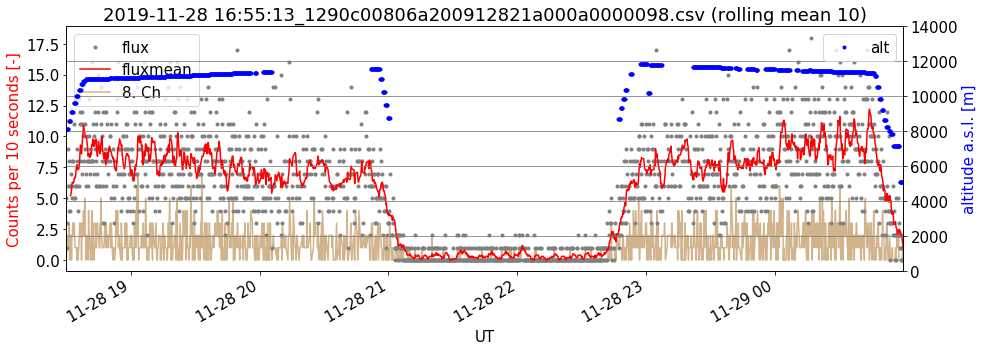

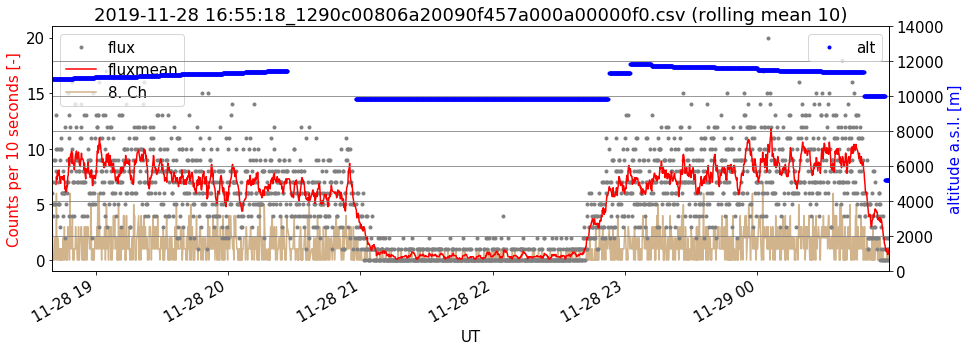

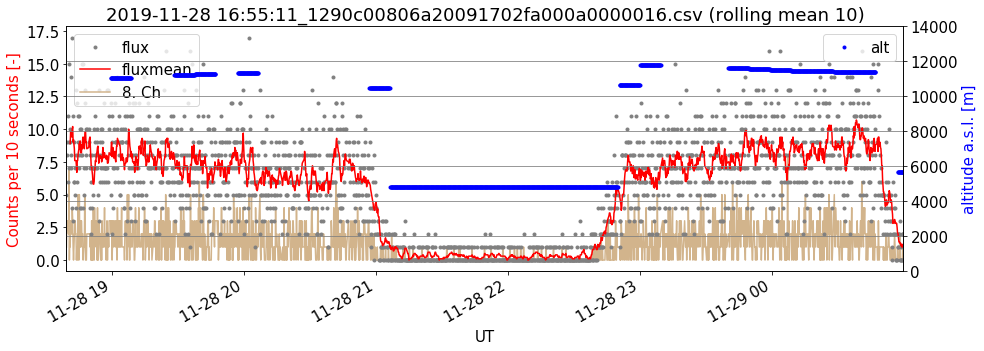

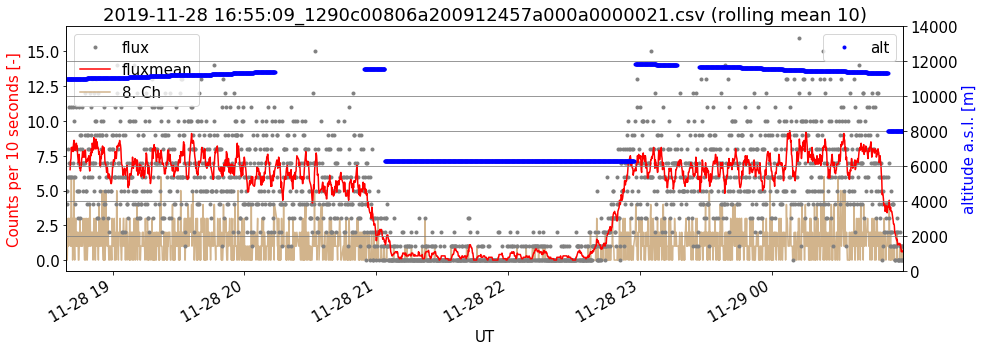

In [96]:
#%matplotlib notebook
%matplotlib inline

matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        #xx = xx.loc['2019-11-28 17:45:00':'2019-11-28 21:10:00']
        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

        xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

        xx['flux'].plot(c='gray', linestyle='', marker='.')
        xx['fluxmean'].plot(c='red')
        xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([0,20])
        plt.xlabel('UT')
        plt.ylabel('Counts per 10 seconds [-]', color='red')
        plt.legend(loc=2)

        ax = plt.twinx()
                
        plt.ylim([0,14000])
        xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
        plt.ylabel('altitude a.s.l. [m]', color='blue')

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
    except:
        pass



# CARI 7

In [717]:
f = './ble.DAT' #  File to Open
df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )


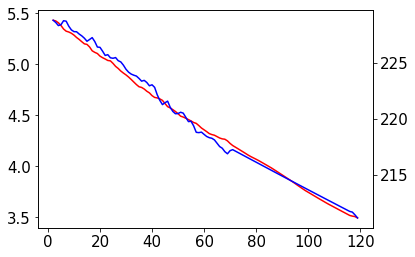

In [718]:
plt.plot(df[3],df[4], c='red')
plt.twinx()
plt.plot(df[3],df[2], c='blue')

## Plot Energy Spectra

0.03850279329608939 -0.040592178770949686
                        5  6  7
date                           
2019-11-28 18:57:35  3128  7  0
2019-11-28 18:57:47  3162  9  2
                        5   6  7
date                            
2019-11-28 18:57:03  4111   8  2
2019-11-28 18:57:15  4044  11  2
                        5   6  7
date                            
2019-11-28 18:56:57  5143  15  0
2019-11-28 18:57:08  5612  14  2
                       5  6  7
date                          
2019-11-28 18:56:57  248  1  1
2019-11-28 18:57:09  247  4  2


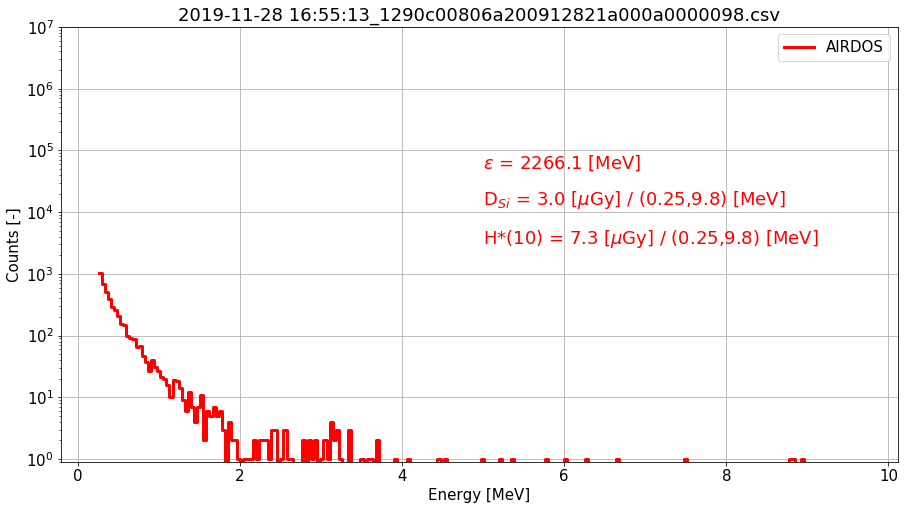

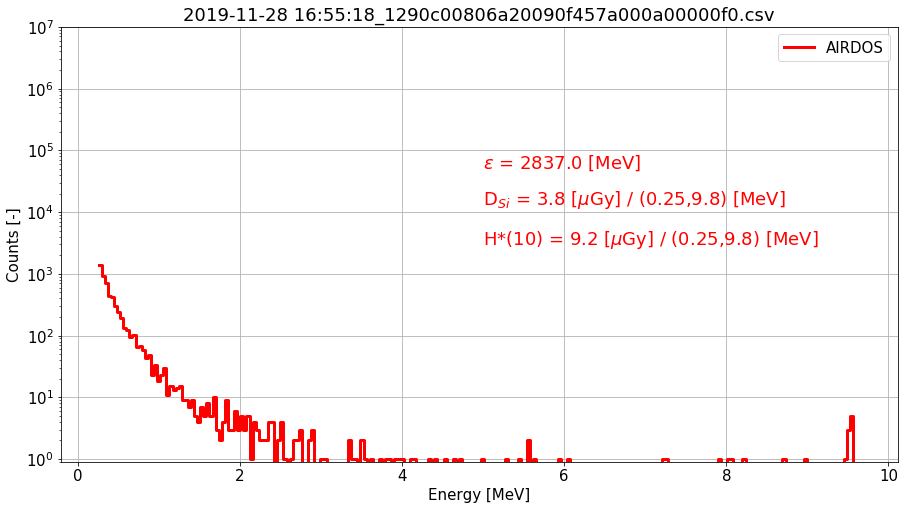

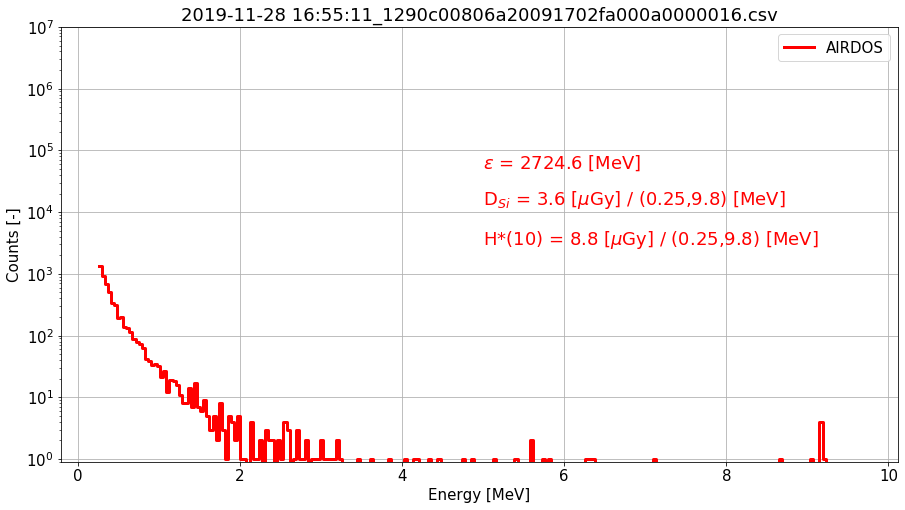

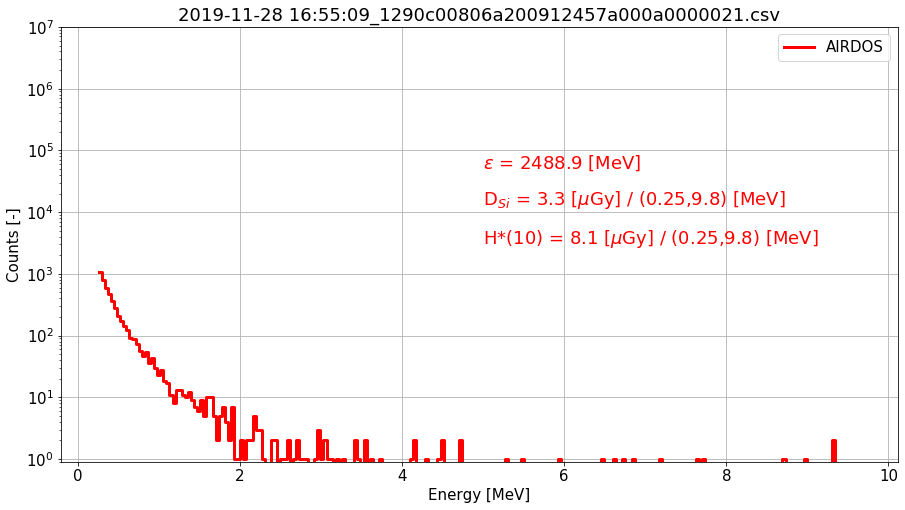

In [164]:
FROM_ENERGY = 0.25
TO_ENERGY = 9.8

l = np.array([[29+4, 1],[208+4,1]]) # Calibration
r = np.array([1.23, 8.122])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])

# force calibration coeficients
coef[0]=0.038
coef[1]=0.105
        
for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:        
        LOW_ENERGY = 7
        
        df = pd.read_csv(f)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace = True)
        
        # Uncomment this if you are interested in a specific time interval
        #xx = df.loc['2019-01-24 05:00:00':'2019-01-24 13:00:00']
        #from 2019-11-28 18:55 to 2019-11-28 20:55 was used for the flight PRG-AGP
        #from 2019-11-28 23:00 to 2019-11-29 00:30 was used for the flight AGP-PRG
        xx = df.loc['2019-11-28 18:55:00':'2019-11-28 20:55:00']
        #xx = df.loc['2019-11-28 23:00':'2019-11-29 00:30']
        #xx = df
        
        ener1 = xx.iloc[:,LOW_ENERGY:255].sum()
        e = pd.DataFrame()
        e['1'] = ener1
        e['index'] = pd.to_numeric(ener1.index)
        e['x'] = (e['index']-LOW_ENERGY+4) * coef[0] + coef[1]
        e['deposit'] = e['1'] * e['x']
        depener = e.loc[(e['x']>=FROM_ENERGY)&(e['x']<=TO_ENERGY),'deposit'].sum() # MeV

        print(xx.iloc[10:12,5:8])

        dose = 1e6*(1.602e-19 * depener*1e6)/0.1398e-3 
       
        # size of the chip (20 mm · 10 mm), 
        # the thickness of the depletion layer (0.3 mm), 
        # and the density of silicon (2.33 g cm^3)
        # 0.1398e-3 kg
        #dose = ((1e6 * (1.602e-19 * depener * 1e6)/0.1398e-3)/10.4) * 3600 # in uGy/h
        #ambient dose = ((1e6 * (1.602e-19 * depener * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uSv/h
        
        
        if (depener > 0):
            plt.figure(figsize=(15,8))
            plt.tight_layout()
            s = f.split('/')
            plt.title(s[len(s)-1])
            plt.yscale('log')
            plt.ylim([0.9,1e7])

            plt.plot(e['x'],e['1'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS')

            '''
            plt.text(5, 50000, r'$\epsilon$ = ' + str(round(depener*1.1,1)) + ' [MeV]', fontsize=18, color='r')
            plt.text(5, 13000, r'D$_S$$_i$ = ' + str(round(dose*1.1,2)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')
            plt.text(5, 3000, r'H*(10) = ' + str(round(dose*1.1*1.142*2.45,2)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')
            '''
            plt.text(5, 50000, r'$\epsilon$ = ' + str(round(depener*1.,1)) + ' [MeV]', fontsize=18, color='r')
            plt.text(5, 13000, r'D$_S$$_i$ = ' + str(round(dose*1.1*1.05,1)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')
            plt.text(5, 3000, r'H*(10) = ' + str(round(dose*1.1*1.05*2.45,1)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')

            plt.legend()
            plt.xlabel('Energy [MeV]')
            plt.ylabel('Counts [-]')
            plt.grid()
    except:
        pass


In [142]:
e

,1,index,x,deposit
7,1062.0,7,0.2582,274.2084
8,800.0,8,0.2966,237.2800
9,584.0,9,0.3350,195.6400
10,463.0,10,0.3734,172.8842
11,361.0,11,0.4118,148.6598
...,...,...,...,...
250,0.0,250,9.5894,0.0000
251,0.0,251,9.6278,0.0000
252,0.0,252,9.6662,0.0000
253,0.0,253,9.7046,0.0000


# Plot Map

<Figure size 1080x360 with 0 Axes>

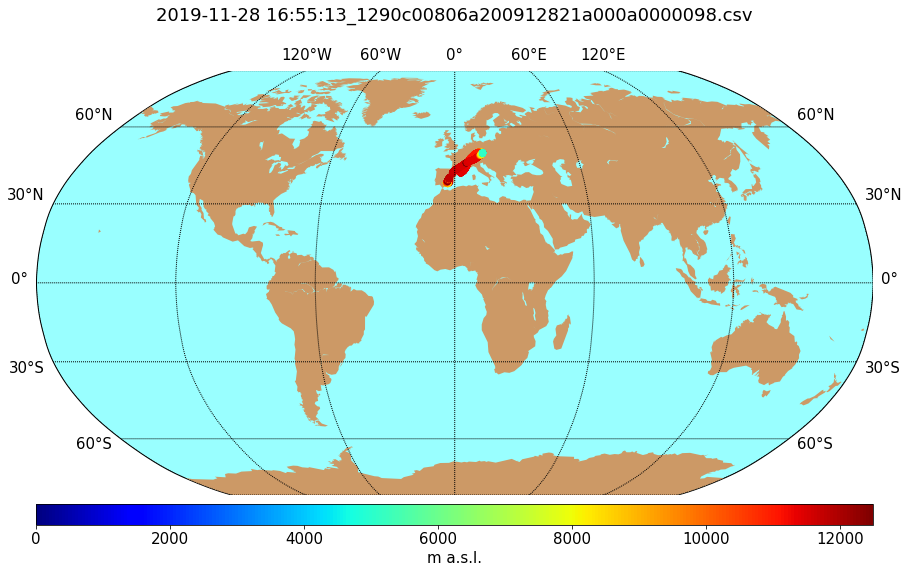

In [7]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


<Figure size 1080x360 with 0 Axes>

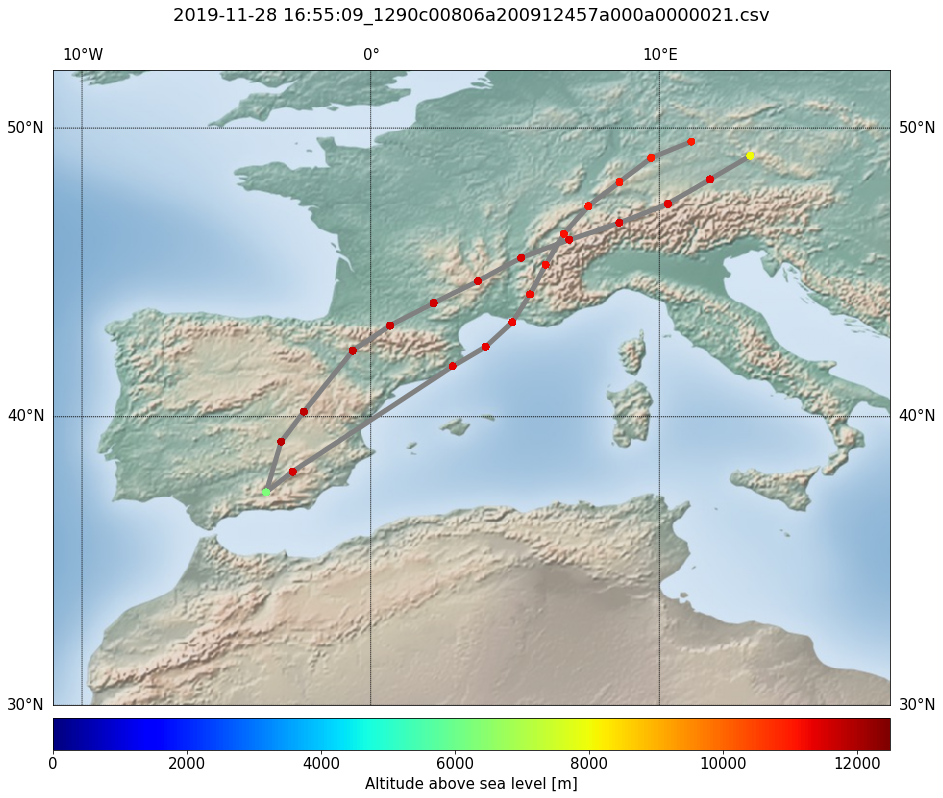

In [21]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=-11,llcrnrlat=30,urcrnrlon=18,urcrnrlat=52)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,10.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
        m.shadedrelief()
        
        m.plot(x,y, zorder=2, color='gray', lw=5)
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet', zorder=99)

        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Altitude above sea level [m]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass
